In [ ]:
!pip install -U efficientnet &> /dev/null
!pip install -U albumentations &> /dev/null
!pip install -U keras_retinanet &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'1.+TABLE+OF+CONTENTS+(Thesis)+-+SAMPLE+1.docx'   Models
'2.+TABLE+OF+CONTENT+(Thesis)+-+SAMPLE+2.docx'	 'My Drive'
'Colab Notebooks'				  NKFoodie.zip
 CXP_EfficientNetB3.h5				  NK_Interim_Report.docx
 Final_Thesis_Sample.pdf			  Public
 images						  yolov3
 LPM						  yolov4


In [ ]:
!cp /mydrive/Public/lsm.h5 /content/

In [ ]:
!cp /mydrive/Public/RSNA_Pneumonia_0M_100F.zip /content/

In [ ]:
!unzip /content/RSNA_Pneumonia_0M_100F -d /content/ &> /dev/null

In [ ]:
parent="RSNA_Pneumonia_0M_100F"
!cp /mydrive/Public/Models/RSNA_Pneumonia_0M_100F.h5 /content/

In [ ]:
# Dataset paths and classes
train_path = parent+"/Train"
val_path=parent+"/Val"
test_path =parent+"/Test"

In [ ]:
#Constants
IMG_SIZE=300
batch_size=16

#Training
lr=1e-5
epochs=70
decay_rate=0.5
patience=5

In [ ]:
#Helper
import random
import numpy as np
import pandas as pd
import os

# Modeling
import tensorflow as tf
import efficientnet.keras as efn 
from keras import Model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,GlobalAveragePooling2D,GlobalMaxPooling2D,Flatten,Conv2D, MaxPooling2D,Activation,Input
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

#RetinaNet Imports
from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image

#Image Processing
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import albumentations as A
from PIL import Image
import keras_preprocessing

#Metrics
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,f1_score
from sklearn import metrics

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

#Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def detect_lungs(xray_file,lsm,threshold=1):
    im = np.array(cv2.imread(xray_file))
    #if there's a PNG it will have alpha channel
    im = im[:,:,:3]
    
    imp = preprocess_image(im)
    imp, scale = resize_image(im)
    
    boxes, scores, labels = lsm.predict_on_batch(np.expand_dims(imp, axis=0))
    
    # standardize box coordinates
    boxes /= scale

    # loop through each prediction for the input image
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < threshold:
            break
            
    box=box.astype(np.int32)
    x0 = box[0]
    y0 = box[1]
    width = box[2]
    height = box[3]
    
    imlungs= im[y0:height , x0:width]
    
    img = Image.fromarray(imlungs)
    img.save(xray_file.replace(".png","_augmented.png"))

In [ ]:
def print_classification_report(y_true,y_pred):
    cf_matrix=confusion_matrix(np.array(y_true), np.array(y_pred))
    sns.heatmap(cf_matrix, annot=True,cmap='Blues',fmt='g')
    print('Classification Report')
    target_names = ['Not Pneumonia', 'Pneumonia']
    print(classification_report(np.array(y_true), y_pred, target_names=target_names,))

In [ ]:
def plot_roc(y_true,y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_true),np.array(y_pred))
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_xray(img):
    xray=img.astype('uint8')
    transform = A.Compose(A.OneOf([A.CLAHE(clip_limit=4)
                                  ,A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=cv2.BORDER_REPLICATE)
                                  ]),p=0.5)
    augmented_image = transform(image=xray)['image']
    return augmented_image.astype('float32')

In [ ]:
def show_xray(xray_path):
    if isinstance(xray_path, str):
        xray=cv2.imread(xray_path)
        plt.imshow(xray)
    else:
        plt.imshow(xray_path)

In [ ]:
!nvidia-smi

Fri May  7 19:15:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
lsm = models.load_model('lsm.h5', backbone_name='resnet50')
lsm = models.convert_model(lsm)

In [ ]:
dir_list=[parent+'/Train/Pneumonia',parent+'/Train/Not Pneumonia']
for directory in dir_list:
  for xray in os.listdir(directory):
    xray_file=directory+"/"+xray
    if random.uniform(0,1) > 0.70:
      detect_lungs(xray_file,lsm)

In [ ]:
#Get the train data
train_datagen= ImageDataGenerator(rescale=1./255.
                                 ,horizontal_flip=True
                                 ,rotation_range=5   
                                 ,brightness_range=[0.8,1.0]
                                 ,shear_range=0.2
                                 #,zoom_range=0.3
                                 ,preprocessing_function=preprocess_xray
                                )
                                 
train_generator=train_datagen.flow_from_directory(
            directory=train_path,
            target_size=(IMG_SIZE,IMG_SIZE),
            batch_size=batch_size,
            shuffle=True
            )

Found 5180 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Not Pneumonia': 0, 'Pneumonia': 1}

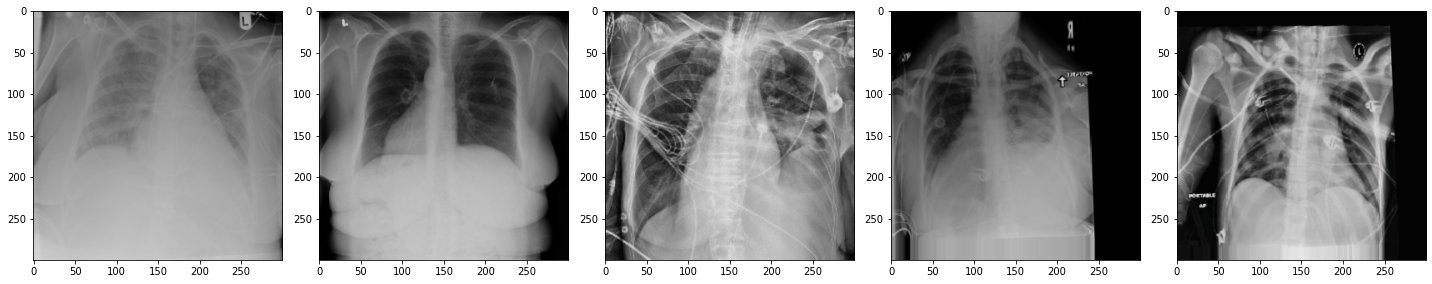

In [ ]:
augmented_images = [train_generator[0][0][i] for i in range(5)]
plotImages(augmented_images)

In [ ]:
val_datagen= ImageDataGenerator(rescale=1./255.)
validation_generator = val_datagen.flow_from_directory(
                        directory=val_path, 
                        target_size=(IMG_SIZE,IMG_SIZE),
                        batch_size=batch_size,
                        shuffle=False
                        )

Found 600 images belonging to 2 classes.


In [ ]:
validation_generator.class_indices

{'Not Pneumonia': 0, 'Pneumonia': 1}

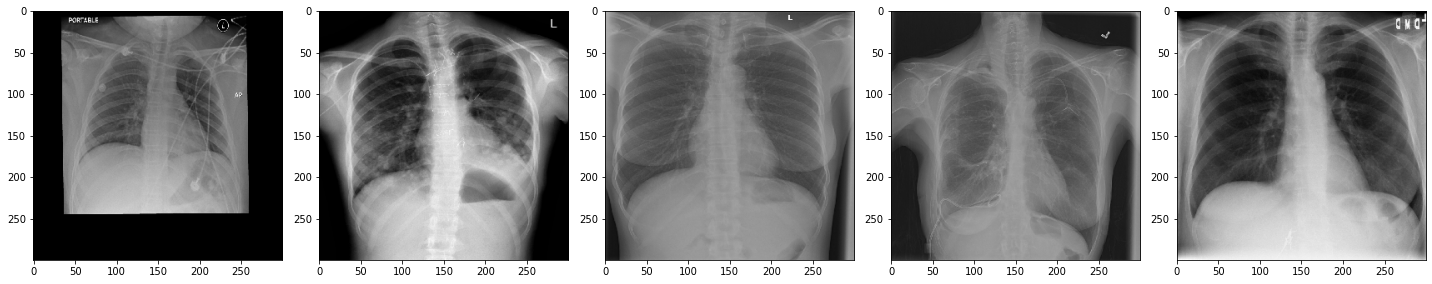

In [ ]:
augmented_images = [validation_generator[0][0][i] for i in range(5)]
plotImages(augmented_images)

In [ ]:
efficientNet = efn.EfficientNetB3(include_top=False,weights='noisy-student',input_shape=(IMG_SIZE,IMG_SIZE,3))

x = efficientNet.output
x = GlobalAveragePooling2D(name='cxr_GlobalAvgPooling')(x)
x = BatchNormalization(name='cxr_BatchNormalization')(x)
x = Dropout(0.4,name="cxr_dropout_1")(x)
x = Dense(units=512,activation='relu',name='cxr_dense512')(x)
x = Dense(units=128,activation='relu',name='cxr_dense128')(x)
x = Dense(units=64,activation='relu',name='cxr_dense64')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax',name='cxr_softmax')(x)
model = Model(inputs=efficientNet.input, outputs=predictions)

model.summary()

43933696/43933088 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
_____________________________

In [ ]:
#optim = SGD(lr=lr, momentum=0.9)
optim=Adam(learning_rate=lr)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'Model/LPM.Epoch{epoch:02d}-Val_Acc{val_accuracy:.3f}_Val_Loss{val_loss:.3f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=False,
                            save_freq='epoch',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True
                            )

rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = patience, factor = decay_rate, verbose = 1,cooldown=1)
estop = EarlyStopping(monitor="val_loss",patience=8,verbose=1,mode="auto")

In [ ]:
history = model.fit(
            train_generator,
            epochs = epochs,
            validation_data = validation_generator,
            verbose = 1,
            callbacks = [model_checkpoint_callback,rlrop]
            )

Epoch 1/70
324/324 [==============================] - 202s 580ms/step - loss: 0.7075 - accuracy: 0.5946 - val_loss: 0.6334 - val_accuracy: 0.6767
Epoch 2/70
324/324 [==============================] - 189s 583ms/step - loss: 0.6215 - accuracy: 0.6871 - val_loss: 0.6030 - val_accuracy: 0.6883
Epoch 3/70
324/324 [==============================] - 186s 573ms/step - loss: 0.5681 - accuracy: 0.7297 - val_loss: 0.5977 - val_accuracy: 0.7050
Epoch 4/70
324/324 [==============================] - 184s 567ms/step - loss: 0.5577 - accuracy: 0.7268 - val_loss: 0.6121 - val_accuracy: 0.7100
Epoch 5/70
324/324 [==============================] - 187s 575ms/step - loss: 0.5438 - accuracy: 0.7376 - val_loss: 0.5995 - val_accuracy: 0.7217
Epoch 6/70
324/324 [==============================] - 187s 576ms/step - loss: 0.5470 - accuracy: 0.7298 - val_loss: 0.5878 - val_accuracy: 0.7233
Epoch 7/70
324/324 [==============================] - 191s 588ms/step - loss: 0.5115 - accuracy: 0.7553 - val_loss: 0.5815 -

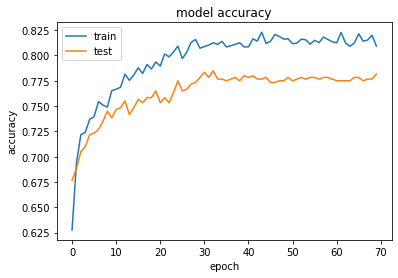

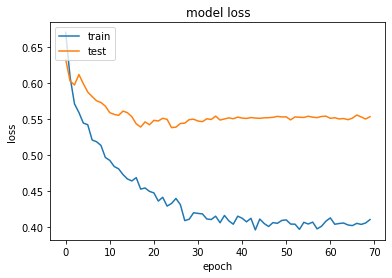

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
model.save(parent+"_LSM.h5")

In [ ]:
test_model=tf.keras.models.load_model(parent+"_LSM.h5")
#test_model=tf.keras.models.load_model('RSNA_Pneumonia_0M_100F.h5')

In [ ]:
!cp /mydrive/Public/Subsets.zip /content/

In [ ]:
!unzip /content/Subsets -d /content/ &> /dev/null

In [ ]:
test_dir_path=[test_path+"/Pneumonia",test_path+"/Not Pneumonia"]

In [ ]:
rsna_df=pd.read_csv("Subsets/"+parent+".csv")

In [ ]:
rsna_df['label_description']=rsna_df['label'].map({0:'Not Pneumonia',1:'Pneumonia'})

In [ ]:
data=[]
for directory in test_dir_path:
    for file in os.listdir(directory):
        data.append(file.replace(".png",".dcm"))

In [ ]:
rsna_test_df=rsna_df[rsna_df['dicom'].isin(data)]

In [ ]:
rsna_test_df['xray_file']=test_path+"/"+rsna_test_df['label_description']+"/"+rsna_test_df['xray']
rsna_test_df['label_description'].value_counts()

Pneumonia        300
Not Pneumonia    300
Name: label_description, dtype: int64

In [ ]:
test_gen=ImageDataGenerator(rescale=1./255.)
test_generator=test_gen.flow_from_dataframe(rsna_test_df
                                           ,x_col='xray_file'
                                           ,y_col='label'
                                           ,target_size=(IMG_SIZE,IMG_SIZE) 
                                           ,class_mode=None
                                           ,shuffle=False
                                           )

Found 600 validated image filenames.


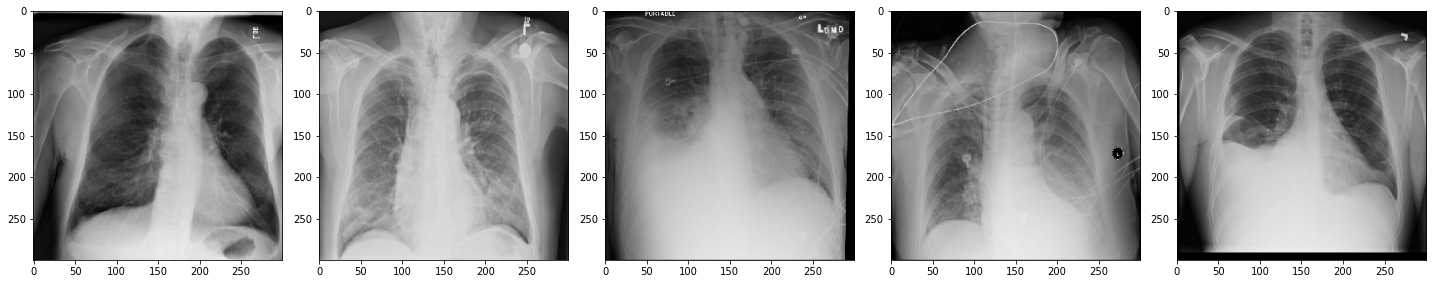

In [ ]:
augmented_images = [test_generator[0][i] for i in range(5)]
plotImages(augmented_images)

In [ ]:
%%time
y_pred = test_model.predict(test_generator)

CPU times: user 9.44 s, sys: 547 ms, total: 9.99 s
Wall time: 9.02 s


In [ ]:
predictions = np.argmax(y_pred, axis=1)
prediction_probs=[class_prob[1] for class_prob in y_pred]
rsna_test_df['ENetB3']=predictions
rsna_test_df['ENetB3_probs']=prediction_probs
rsna_test_df['ENetB3_description']=rsna_test_df['ENetB3'].map({0:'Not Pneumonia',1:'Pneumonia'})

In [ ]:
f1_score(rsna_test_df['label'].values,rsna_test_df['ENetB3'].values,average='micro')

0.775

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.79      0.75      0.77       300
    Pneumonia       0.76      0.80      0.78       300

     accuracy                           0.78       600
    macro avg       0.78      0.78      0.77       600
 weighted avg       0.78      0.78      0.77       600



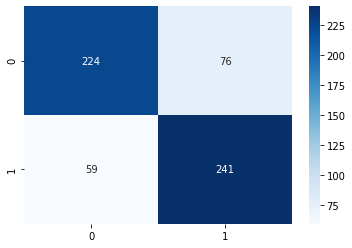

In [ ]:
print_classification_report(rsna_test_df['label'].values,rsna_test_df['ENetB3'].values)

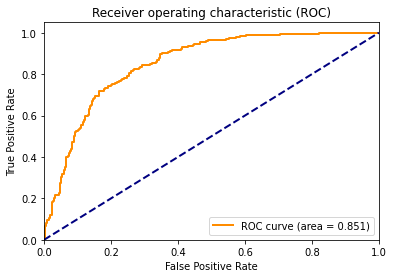

In [ ]:
plot_roc(rsna_test_df['label'].values,rsna_test_df['ENetB3_probs'].values)

In [ ]:
f1_score(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3'].values,average='micro')

0.79

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.81      0.75      0.78       150
    Pneumonia       0.77      0.83      0.80       150

     accuracy                           0.79       300
    macro avg       0.79      0.79      0.79       300
 weighted avg       0.79      0.79      0.79       300



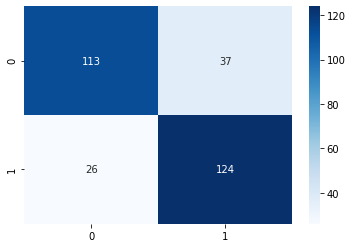

In [ ]:
print_classification_report(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3'].values)

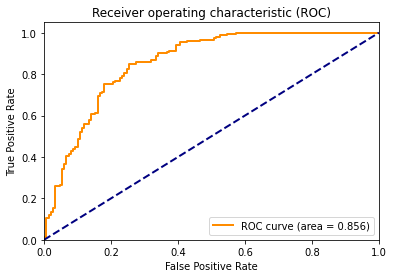

In [ ]:
plot_roc(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3_probs'].values)

In [ ]:
f1_score(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3'].values,average='micro')

0.76

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.77      0.74      0.76       150
    Pneumonia       0.75      0.78      0.76       150

     accuracy                           0.76       300
    macro avg       0.76      0.76      0.76       300
 weighted avg       0.76      0.76      0.76       300



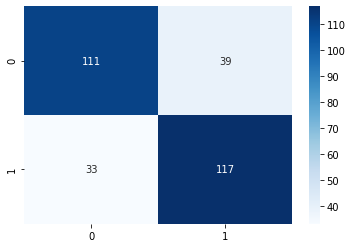

In [ ]:
print_classification_report(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3'].values)

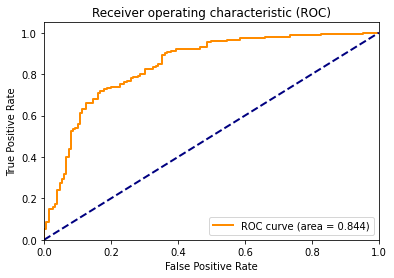

In [ ]:
plot_roc(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3_probs'].values)

In [ ]:
detailed_truth=pd.read_csv('Subsets/stage_2_detailed_class_info.csv')
detailed_truth.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
pathology="Not Pneumonia"
nofinding_errors=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)]

In [ ]:
def get_detailed_truth(df):
    return detailed_truth[detailed_truth['patientId']==df['patient_id']]['class'].values[0]

In [ ]:
nofinding_errors['detailed_truth']=nofinding_errors.apply(get_detailed_truth,axis=1)
nofinding_errors[['label_description','detailed_truth','ENetB3_description']].groupby(['detailed_truth']).count()

,label_description,ENetB3_description
detailed_truth,,
No Lung Opacity / Not Normal,72,72
Normal,4,4


In [ ]:
pathology="Pneumonia"
pneumonia_errors=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)]

In [ ]:
pneumonia_errors['detailed_truth']=pneumonia_errors.apply(get_detailed_truth,axis=1)
pneumonia_errors[['label_description','detailed_truth','ENetB3_description']].groupby(['detailed_truth']).count()

,label_description,ENetB3_description
detailed_truth,,
Lung Opacity,59,59


In [ ]:
pathology="Not Pneumonia"
rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)][['xray','sex','label_description','ENetB3_description','ENetB3_probs']].head(5)

,xray,sex,label_description,ENetB3_description,ENetB3_probs
2198,d1cf6d7d-0e8f-4c94-8ce7-739388aed78a.png,M,Not Pneumonia,Pneumonia,0.654251
2202,55e8ab4e-b6c3-4424-bae7-3b17849a1141.png,M,Not Pneumonia,Pneumonia,0.964014
2207,695b6d1e-f8d7-426a-8abe-aba77943ab71.png,M,Not Pneumonia,Pneumonia,0.979150
2210,11d8e718-ca03-4f4d-95fc-da6d9ba1434f.png,M,Not Pneumonia,Pneumonia,0.511655
2221,432c08e5-3a4f-4b42-9726-2f18f77aa0d4.png,M,Not Pneumonia,Pneumonia,0.978542


In [ ]:
pathology="Pneumonia"
rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)][['xray','sex','label_description','ENetB3_description','ENetB3_probs']].head(5)

,xray,sex,label_description,ENetB3_description,ENetB3_probs
4190,dc7720ba-e9fe-4680-8304-bb149bedf128.png,M,Pneumonia,Not Pneumonia,0.302589
4195,32764f2f-ea89-4d7c-aa7d-e70366218270.png,M,Pneumonia,Not Pneumonia,0.013402
4200,3d824fdb-8d06-4e9b-84dd-67f121be3874.png,M,Pneumonia,Not Pneumonia,0.127951
4201,1614564a-fe0d-43dc-87ae-299d859959f6.png,M,Pneumonia,Not Pneumonia,0.028122
4208,3ba80992-3ec3-421a-97b8-354f1a5dbae1.png,M,Pneumonia,Not Pneumonia,0.326304


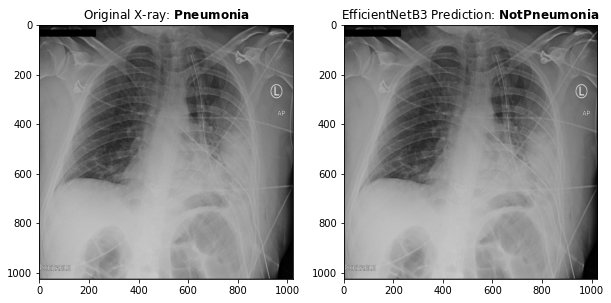

In [ ]:
df_index=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)].index[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
show_xray(rsna_test_df.loc[df_index]['xray_file'])
plt.title("Original X-ray: "+ r"$\bf{Pneumonia"+ "}$");
plt.subplot(1,2,2)
show_xray(rsna_test_df.loc[df_index]['xray_file'])
plt.title("EfficientNetB3 Prediction: "+ r"$\bf{Not Pneumonia"+ "}$");

In [ ]:
!cp "/content/RSNA_Pneumonia_0M_100F_LSM.h5" /mydrive/Public/